In [1]:
!pip install -q spacy nltk pandas numpy matplotlib seaborn plotly beautifulsoup4 lxml requests tqdm scikit-learn
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Core data manipulation
import pandas as pd
import numpy as np
from pathlib import Path
import json
import re
from collections import Counter, defaultdict
from itertools import chain

# Web scraping
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time

# NLP
import spacy
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Utilities
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [3]:
# Fetch the master index
MASTER_INDEX_URL = "https://www.ramakrishnavivekananda.info/vivekananda/master_index.htm"

print(f"Fetching master index from:\n{MASTER_INDEX_URL}\n")

response = requests.get(MASTER_INDEX_URL)
response.raise_for_status()  # Raise error if request failed

# Parse HTML
soup = BeautifulSoup(response.content, 'lxml')

# Save raw HTML for inspection
raw_html_path = Path("master_index_raw.html")
raw_html_path.write_text(response.text, encoding='utf-8')

print(f"✓ Master index fetched successfully")
print(f"✓ Raw HTML saved to: {raw_html_path}")
print(f"✓ Response length: {len(response.text):,} characters")
print(f"\nReady for exploration!")

Fetching master index from:
https://www.ramakrishnavivekananda.info/vivekananda/master_index.htm

✓ Master index fetched successfully
✓ Raw HTML saved to: master_index_raw.html
✓ Response length: 138,750 characters

Ready for exploration!


In [4]:
# Deep dive into the master index HTML structure

print("="*80)
print("MASTER INDEX HTML STRUCTURE ANALYSIS")
print("="*80)

# 1. Basic HTML structure
print("\n1. TOP-LEVEL HTML STRUCTURE")
print("-" * 40)
print(f"Title: {soup.title.string if soup.title else 'No title'}")
print(f"Number of <div> tags: {len(soup.find_all('div'))}")
print(f"Number of <table> tags: {len(soup.find_all('table'))}")
print(f"Number of <ul>/<ol> tags: {len(soup.find_all(['ul', 'ol']))}")

# 2. All links analysis
print("\n2. LINKS ANALYSIS")
print("-" * 40)
all_links = soup.find_all('a', href=True)
print(f"Total number of links: {len(all_links)}")

# Categorize links by extension/type
link_types = defaultdict(list)
for link in all_links:
    href = link['href']
    if href.endswith('.htm') or href.endswith('.html'):
        link_types['html'].append(href)
    elif href.startswith('http'):
        link_types['external'].append(href)
    elif href.startswith('#'):
        link_types['anchor'].append(href)
    else:
        link_types['other'].append(href)

for link_type, links in link_types.items():
    print(f"  {link_type.upper()}: {len(links)} links")

# 3. Sample the first 10 HTML links to see structure
print("\n3. SAMPLE HTML LINKS (first 10)")
print("-" * 40)
for i, href in enumerate(link_types['html'][:10], 1):
    link_elem = soup.find('a', href=href)
    link_text = link_elem.get_text(strip=True) if link_elem else "No text"
    print(f"{i:2d}. {href}")
    print(f"    Text: {link_text[:80]}{'...' if len(link_text) > 80 else ''}")

# 4. Look for structural patterns - headings
print("\n4. HEADINGS & STRUCTURE")
print("-" * 40)
for level in range(1, 7):
    headings = soup.find_all(f'h{level}')
    if headings:
        print(f"<h{level}> tags: {len(headings)}")
        for h in headings[:3]:  # Show first 3 of each level
            print(f"  → {h.get_text(strip=True)[:80]}")

# 5. Check for volume/chapter organization patterns
print("\n5. SEARCHING FOR ORGANIZATIONAL KEYWORDS")
print("-" * 40)
keywords = ['volume', 'chapter', 'lecture', 'letter', 'conversation',
            'poem', 'inspired talk', 'discourse', 'notes']
text_lower = soup.get_text().lower()

for keyword in keywords:
    count = text_lower.count(keyword)
    if count > 0:
        print(f"  '{keyword}': appears {count} times")

# 6. Get a sense of the overall text structure (first 2000 chars)
print("\n6. DOCUMENT TEXT PREVIEW (first 2000 chars)")
print("-" * 40)
full_text = soup.get_text(separator='\n', strip=True)
print(full_text[:2000])

print("\n" + "="*80)
print("EXPLORATION COMPLETE - Ready for next steps")
print("="*80)

MASTER INDEX HTML STRUCTURE ANALYSIS

1. TOP-LEVEL HTML STRUCTURE
----------------------------------------
Title: Complete Works -- Master Index
Number of <div> tags: 62
Number of <table> tags: 0
Number of <ul>/<ol> tags: 0

2. LINKS ANALYSIS
----------------------------------------
Total number of links: 1459
  HTML: 1458 links
  EXTERNAL: 1 links

3. SAMPLE HTML LINKS (first 10)
----------------------------------------
 1. ../index.htm
    Text: Home
 2. complete_works.htm
    Text: Complete-Works
 3. volume_1/addresses_at_the_parliament/v1_c1_response_to_welcome.htm
    Text: Response
to Welcome
 4. volume_1/addresses_at_the_parliament/v1_c1_why_we_disagreee.htm
    Text: Why
We Disagree
 5. volume_1/addresses_at_the_parliament/v1_c1_paper_on_hinduism.htm
    Text: Paper
on Hinduism
 6. volume_1/addresses_at_the_parliament/v1_c1_crying_need.htm
    Text: Religion
not the Crying Need of India
 7. volume_1/addresses_at_the_parliament/v1_c1_buddhism.htm
    Text: Buddhism
 8. volume_1/

In [10]:
# Find and download the XLSX index file

print("Searching for XLSX link in master index...\n")

# Find all links that point to .xlsx files
xlsx_links = [link for link in soup.find_all('a', href=True)
              if link['href'].endswith('.xlsx')]

if xlsx_links:
    xlsx_href = xlsx_links[0]['href']
    xlsx_url = urljoin(MASTER_INDEX_URL, xlsx_href)
    print(f"Found XLSX file: {xlsx_href}")
    print(f"Full URL: {xlsx_url}\n")

    # Download the file
    print("Downloading XLSX file...")
    xlsx_response = requests.get(xlsx_url)
    xlsx_response.raise_for_status()

    # Save locally
    xlsx_path = Path("complete_works_index.xlsx")
    xlsx_path.write_bytes(xlsx_response.content)
    print(f"✓ XLSX file saved to: {xlsx_path}")
    print(f"✓ File size: {len(xlsx_response.content):,} bytes\n")

    # Load and explore
    print("="*80)
    print("EXPLORING XLSX STRUCTURE")
    print("="*80)

    # Read the file
    df_xlsx = pd.read_excel(xlsx_path)

    print(f"\nShape: {df_xlsx.shape[0]} rows × {df_xlsx.shape[1]} columns")
    print(f"\nColumn names:")
    for i, col in enumerate(df_xlsx.columns, 1):
        print(f"  {i:2d}. {col}")

    print(f"\n" + "="*80)
    print("FIRST 20 ROWS")
    print("="*80)
    print(df_xlsx.head(20).to_string())

    print(f"\n" + "="*80)
    print("RANDOM SAMPLE (10 rows)")
    print("="*80)
    print(df_xlsx.sample(min(10, len(df_xlsx))).to_string())

    print(f"\n" + "="*80)
    print("DATA TYPES & MISSING VALUES")
    print("="*80)
    print(df_xlsx.info())

else:
    print("No XLSX file found in master index!")

Searching for XLSX link in master index...

Found XLSX file: http://ramakrishnavivekananda.info/vivekananda/completeworksindex.xlsx
Full URL: http://ramakrishnavivekananda.info/vivekananda/completeworksindex.xlsx

✓ XLSX file saved to: complete_works_index.xlsx
✓ File size: 155,172 bytes

EXPLORING XLSX STRUCTURE

Shape: 1450 rows × 10 columns

Column names:
   1. Index 
   2. Volume
   3. Name
   4. Category 
   5. Type
   6. Date
   7. Place
   8. Source
   9. Audience
  10. Language

FIRST 20 ROWS
   Index   Volume                                        Name                                 Category      Type        Date                         Place             Source           Audience Language
0       1     1.0                                Introduction                        Editorial Foreword      NaN  1907/07/04                           NaN                NaN                NaN  English
1       2     1.0                         Response to Welcome  Addresses at the Parliament

In [5]:
# Parse all links into structured data

print("Parsing all content links from master index...\n")

# Get all HTML links (excluding home/navigation)
content_links = []

for link in soup.find_all('a', href=True):
    href = link['href']

    # Filter: only content links (starting with 'volume_')
    if href.startswith('volume_'):
        link_text = link.get_text(separator=' ', strip=True)
        content_links.append({
            'href': href,
            'link_text': link_text,
            'full_url': urljoin(MASTER_INDEX_URL, href)
        })

print(f"Found {len(content_links)} content links\n")

# Convert to dataframe
df_links = pd.DataFrame(content_links)

# Extract metadata from href paths
df_links['volume'] = df_links['href'].str.extract(r'(volume_\d+)')[0]
df_links['section'] = df_links['href'].str.extract(r'volume_\d+/([^/]+)/')[0]
df_links['filename'] = df_links['href'].str.split('/').str[-1]

# Display sample
print("="*80)
print("SAMPLE OF PARSED LINKS")
print("="*80)
print(df_links.head(20).to_string(index=False))

print("\n" + "="*80)
print("VOLUME DISTRIBUTION")
print("="*80)
print(df_links['volume'].value_counts().sort_index())

print("\n" + "="*80)
print("SECTION DISTRIBUTION (Top 20)")
print("="*80)
section_counts = df_links['section'].value_counts().head(20)
print(section_counts.to_string())

print(f"\n✓ Total unique volumes: {df_links['volume'].nunique()}")
print(f"✓ Total unique sections: {df_links['section'].nunique()}")
print(f"✓ Total documents: {len(df_links)}")

# Save for later use
df_links.to_csv('master_index_links.csv', index=False)
print(f"\n✓ Links saved to: master_index_links.csv")

Parsing all content links from master index...

Found 1412 content links

SAMPLE OF PARSED LINKS
                                                              href                                    link_text                                                                                                               full_url   volume                     section                      filename
volume_1/addresses_at_the_parliament/v1_c1_response_to_welcome.htm                         Response\nto Welcome https://www.ramakrishnavivekananda.info/vivekananda/volume_1/addresses_at_the_parliament/v1_c1_response_to_welcome.htm volume_1 addresses_at_the_parliament v1_c1_response_to_welcome.htm
   volume_1/addresses_at_the_parliament/v1_c1_why_we_disagreee.htm                             Why\nWe Disagree    https://www.ramakrishnavivekananda.info/vivekananda/volume_1/addresses_at_the_parliament/v1_c1_why_we_disagreee.htm volume_1 addresses_at_the_parliament    v1_c1_why_we_disagreee.htm
  volume_

In [7]:
# Detailed analysis of corpus structure by volume and section

print("="*80)
print("CORPUS STRUCTURE ANALYSIS")
print("="*80)

# Check for missing sections
print(f"\nMissing sections: {df_links['section'].isna().sum()}")
if df_links['section'].isna().sum() > 0:
    print("\nRows with missing sections:")
    print(df_links[df_links['section'].isna()][['href', 'link_text', 'volume']].head(10))
    print("\n→ Filling missing sections with 'uncategorized'\n")
    df_links['section'] = df_links['section'].fillna('uncategorized')

# 1. All unique sections with counts
print("\n1. ALL SECTIONS IN THE CORPUS (sorted by document count)")
print("-"*80)
section_counts = df_links['section'].value_counts()
print(f"Total unique sections: {len(section_counts)}\n")

section_df = pd.DataFrame({
    'section': section_counts.index,
    'document_count': section_counts.values
})
print(section_df.to_string(index=False))

# 2. Volume × Section crosstab (showing only non-zero cells for readability)
print("\n\n2. DOCUMENT DISTRIBUTION: VOLUME × SECTION")
print("-"*80)
crosstab = pd.crosstab(df_links['volume'], df_links['section'], margins=True)
print(crosstab)

# 3. Genre classification (heuristic based on section names)
print("\n\n3. GENRE CLASSIFICATION (Heuristic)")
print("-"*80)

def classify_genre(section_name):
    """Heuristic genre classifier based on section name"""
    if pd.isna(section_name):
        return 'Other'

    section = str(section_name).lower()

    if 'letter' in section or 'epistle' in section:
        return 'Letters'
    elif 'lecture' in section or 'discourse' in section or 'talk' in section or 'address' in section:
        return 'Lectures'
    elif 'conversation' in section or 'dialogue' in section:
        return 'Conversations'
    elif 'report' in section:
        return 'Reports'
    elif 'poem' in section or 'prose' in section or 'writings' in section:
        return 'Writings'
    elif 'note' in section:
        return 'Notes'
    elif 'yoga' in section:
        return 'Treatises'
    else:
        return 'Other'

df_links['genre'] = df_links['section'].apply(classify_genre)

genre_counts = df_links['genre'].value_counts()
print(genre_counts.to_string())
print(f"\nTotal: {genre_counts.sum()} documents")

# 4. Genre distribution by volume
print("\n\n4. GENRE DISTRIBUTION BY VOLUME")
print("-"*80)
genre_by_volume = pd.crosstab(df_links['volume'], df_links['genre'], margins=True)
print(genre_by_volume)

# 5. Summary statistics
print("\n\n5. SUMMARY STATISTICS")
print("-"*80)
print(f"Total documents: {len(df_links)}")
print(f"Total volumes: {df_links['volume'].nunique()}")
print(f"Total sections: {df_links['section'].nunique()}")
print(f"Total genres: {df_links['genre'].nunique()}")
print(f"\nAverage docs per volume: {len(df_links) / df_links['volume'].nunique():.1f}")
print(f"Average docs per section: {len(df_links) / df_links['section'].nunique():.1f}")

# Save enhanced dataframe
df_links.to_csv('master_index_links_with_genre.csv', index=False)
print(f"\n✓ Enhanced links with genre saved to: master_index_links_with_genre.csv")

CORPUS STRUCTURE ANALYSIS

Missing sections: 9

Rows with missing sections:
                                              href  \
51                volume_2/work_and_its_secret.htm   
52             volume_2/the_powers_of_the_mind.htm   
53    volume_2/hints_on_practical_spirituality.htm   
54                 volume_2/bhakti_or_devotion.htm   
170                  volume_3/buddhistic_india.htm   
404            volume_5/sayings_and_utterances.htm   
855            volume_8/sayings_and_utterances.htm   
1307     volume_9/conversations_and_interviews.htm   
1323           volume_9/sayings_and_utterances.htm   

                             link_text    volume  
51                 Work and its Secret  volume_2  
52              The Powers of the Mind  volume_2  
53    Hints on Practical\nSpirituality  volume_2  
54                  Bhakti or Devotion  volume_2  
170                   Buddhistic India  volume_3  
404             Sayings and Utterances  volume_5  
855             Sayings an

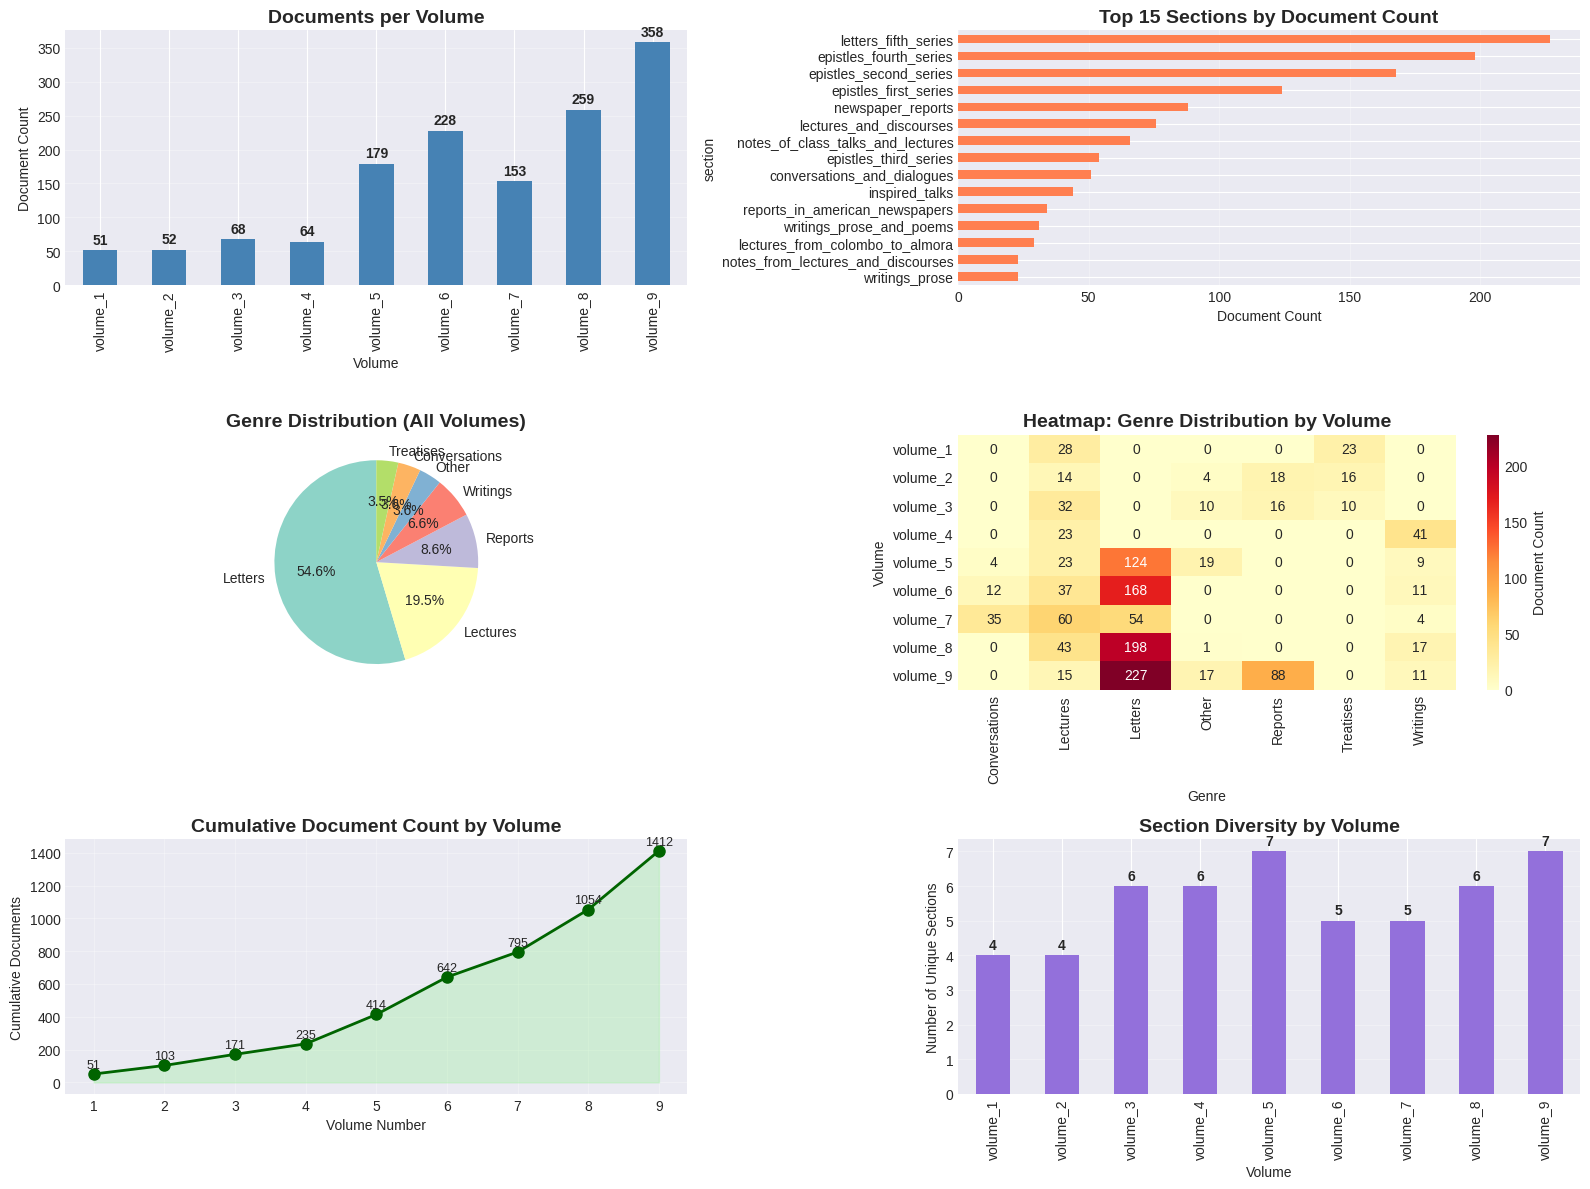

✓ Visualization saved as: corpus_structure_overview.png


In [8]:
# Visual exploration of corpus structure

fig = plt.figure(figsize=(16, 12))

# 1. Documents per volume
ax1 = plt.subplot(3, 2, 1)
volume_counts = df_links['volume'].value_counts().sort_index()
volume_counts.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Documents per Volume', fontsize=14, fontweight='bold')
ax1.set_xlabel('Volume')
ax1.set_ylabel('Document Count')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(volume_counts.values):
    ax1.text(i, v + 5, str(v), ha='center', va='bottom', fontweight='bold')

# 2. Top 15 sections
ax2 = plt.subplot(3, 2, 2)
top_sections = df_links['section'].value_counts().head(15)
top_sections.plot(kind='barh', ax=ax2, color='coral')
ax2.set_title('Top 15 Sections by Document Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Document Count')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# 3. Genre distribution (pie chart)
ax3 = plt.subplot(3, 2, 3)
genre_counts = df_links['genre'].value_counts()
colors = plt.cm.Set3(range(len(genre_counts)))
ax3.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%',
        startangle=90, colors=colors)
ax3.set_title('Genre Distribution (All Volumes)', fontsize=14, fontweight='bold')

# 4. Heatmap: Volume × Genre
ax4 = plt.subplot(3, 2, 4)
genre_by_vol = pd.crosstab(df_links['volume'], df_links['genre'])
sns.heatmap(genre_by_vol, annot=True, fmt='d', cmap='YlOrRd',
            ax=ax4, cbar_kws={'label': 'Document Count'})
ax4.set_title('Heatmap: Genre Distribution by Volume', fontsize=14, fontweight='bold')
ax4.set_xlabel('Genre')
ax4.set_ylabel('Volume')

# 5. Cumulative documents across volumes
ax5 = plt.subplot(3, 2, 5)
cumulative = volume_counts.cumsum()
ax5.plot(range(1, len(cumulative)+1), cumulative.values,
         marker='o', linewidth=2, markersize=8, color='darkgreen')
ax5.fill_between(range(1, len(cumulative)+1), cumulative.values, alpha=0.3, color='lightgreen')
ax5.set_title('Cumulative Document Count by Volume', fontsize=14, fontweight='bold')
ax5.set_xlabel('Volume Number')
ax5.set_ylabel('Cumulative Documents')
ax5.set_xticks(range(1, 10))
ax5.grid(alpha=0.3)
for i, v in enumerate(cumulative.values):
    ax5.text(i+1, v + 20, str(v), ha='center', va='bottom', fontsize=9)

# 6. Section diversity by volume (number of unique sections)
ax6 = plt.subplot(3, 2, 6)
section_diversity = df_links.groupby('volume')['section'].nunique().sort_index()
section_diversity.plot(kind='bar', ax=ax6, color='mediumpurple')
ax6.set_title('Section Diversity by Volume', fontsize=14, fontweight='bold')
ax6.set_xlabel('Volume')
ax6.set_ylabel('Number of Unique Sections')
ax6.grid(axis='y', alpha=0.3)
for i, v in enumerate(section_diversity.values):
    ax6.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('corpus_structure_overview.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as: corpus_structure_overview.png")

In [14]:
# Merge XLSX metadata with HTML links

print("="*80)
print("MERGING XLSX METADATA WITH HTML LINKS")
print("="*80)

# First, let's understand the ID/matching strategy
print("\n1. CHECKING MATCHING STRATEGY")
print("-"*40)

# The XLSX has an 'Index' column - let's see if it maps to anything
print(f"XLSX rows: {len(df_xlsx)}")
print(f"HTML links: {len(df_links)}")
print(f"Difference: {len(df_xlsx) - len(df_links)} rows")

# Check data types
print(f"\nXLSX Volume type: {df_xlsx['Volume'].dtype}")
print(f"HTML volume type: {df_links['volume'].dtype}")

# Fix: Convert Volume to string for matching
df_xlsx['volume_str'] = df_xlsx['Volume'].astype(int).astype(str)
df_links['volume_str'] = df_links['volume'].str.replace('volume_', '')

print(f"\nAfter conversion:")
print(f"XLSX volume_str sample: {df_xlsx['volume_str'].head(3).tolist()}")
print(f"HTML volume_str sample: {df_links['volume_str'].head(3).tolist()}")

# Check if we can match by Name
print("\n2. SAMPLE NAME COMPARISON")
print("-"*40)
print("XLSX Name examples:")
print(df_xlsx['Name'].head(10).tolist())
print("\nHTML link_text examples:")
print(df_links['link_text'].head(10).tolist())

# They look different (XLSX cleaner, HTML has newlines)
# Let's try matching by volume + normalized name

def normalize_text(text):
    """Normalize text for matching"""
    if pd.isna(text):
        return ""
    return str(text).lower().strip().replace('\n', ' ').replace('  ', ' ')

# Add normalized columns for matching
df_xlsx['name_normalized'] = df_xlsx['Name'].apply(normalize_text)
df_links['text_normalized'] = df_links['link_text'].apply(normalize_text)

# Try to match by volume + name
print("\n3. ATTEMPTING MERGE BY VOLUME + NAME")
print("-"*40)

# Merge on volume and normalized name
df_merged = df_xlsx.merge(
    df_links[['volume_str', 'text_normalized', 'href', 'full_url', 'filename', 'section', 'genre']],
    how='left',
    left_on=['volume_str', 'name_normalized'],
    right_on=['volume_str', 'text_normalized'],
    suffixes=('_xlsx', '_html')
)

# Check merge success
matched = df_merged['href'].notna().sum()
unmatched = df_merged['href'].isna().sum()

print(f"✓ Matched: {matched} rows ({matched/len(df_merged)*100:.1f}%)")
print(f"✗ Unmatched: {unmatched} rows ({unmatched/len(df_merged)*100:.1f}%)")

# Show sample of matched rows
print("\n4. SAMPLE OF MATCHED ROWS")
print("-"*40)
sample_matched = df_merged[df_merged['href'].notna()].head(5)
# Use actual column names (they have trailing spaces from XLSX)
print(sample_matched[['Name', 'Category ', 'Type', 'Date', 'Place', 'href']].to_string(index=False))

# Show sample of unmatched rows
print("\n5. SAMPLE OF UNMATCHED ROWS (need investigation)")
print("-"*40)
sample_unmatched = df_merged[df_merged['href'].isna()].head(10)
print(sample_unmatched[['Index ', 'Volume', 'Name', 'Category ', 'Type']].to_string(index=False))

# Clean up column names (remove trailing spaces)
df_merged.columns = df_merged.columns.str.strip()

# Clean up merge columns
if 'text_normalized' in df_merged.columns:
    df_merged = df_merged.drop(columns=['text_normalized'])
if 'volume_str' in df_merged.columns:
    df_merged = df_merged.drop(columns=['volume_str'])

# Rename Volume to volume for consistency
df_merged = df_merged.rename(columns={'Volume': 'volume'})

print(f"\n✓ Merged dataframe shape: {df_merged.shape}")
print(f"✓ Columns after cleanup: {list(df_merged.columns)}")

# Save intermediate result
df_merged.to_csv('master_dataset_merged.csv', index=False)
print(f"\n✓ Merged dataset saved to: master_dataset_merged.csv")

MERGING XLSX METADATA WITH HTML LINKS

1. CHECKING MATCHING STRATEGY
----------------------------------------
XLSX rows: 1450
HTML links: 1412
Difference: 38 rows

XLSX Volume type: float64
HTML volume type: object

After conversion:
XLSX volume_str sample: ['1', '1', '1']
HTML volume_str sample: ['1', '1', '1']

2. SAMPLE NAME COMPARISON
----------------------------------------
XLSX Name examples:
['Introduction', 'Response to Welcome', 'Why We Disagree', 'Paper on Hinduism', 'Religion not the Crying Need of India', 'Buddhism, the Fulfilment of Hinduism', 'Address at the Final Session', 'Karma in its Effect on Character', 'Each is great in his own place', 'The Secret of Work']

HTML link_text examples:
['Response\nto Welcome', 'Why\nWe Disagree', 'Paper\non Hinduism', 'Religion\nnot the Crying Need of India', 'Buddhism', ',\nthe Fulfilment of Hinduism', 'Address\nat the Final Session', 'Karma in\nits Effect on\nCharacter', 'Each\nis great in his own place', 'The Secret of\nWork']

3. 

In [15]:
# Deep dive into unmatched entries from both XLSX and HTML

print("="*80)
print("UNMATCHED ENTRIES ANALYSIS")
print("="*80)

# 1. XLSX entries that didn't match to HTML
print("\n1. XLSX ENTRIES WITHOUT HTML LINKS (148 rows)")
print("-"*80)
unmatched_xlsx = df_merged[df_merged['href'].isna()].copy()
print(f"Total unmatched from XLSX: {len(unmatched_xlsx)}\n")

# Breakdown by volume
print("Unmatched by Volume:")
print(unmatched_xlsx['volume'].value_counts().sort_index())

print("\nUnmatched by Category:")
print(unmatched_xlsx['Category'].value_counts())

print("\nUnmatched by Type:")
print(unmatched_xlsx['Type'].value_counts())

# Show all unmatched entries
print("\n" + "="*80)
print("ALL UNMATCHED XLSX ENTRIES:")
print("="*80)
unmatched_display = unmatched_xlsx[['Index', 'volume', 'Name', 'Category', 'Type']].copy()
unmatched_display['volume'] = unmatched_display['volume'].astype(int)
print(unmatched_display.to_string(index=False))

# 2. HTML links that didn't match to XLSX
print("\n\n" + "="*80)
print("2. HTML LINKS WITHOUT XLSX METADATA")
print("="*80)

# Find HTML links not in merged data
matched_hrefs = set(df_merged['href'].dropna())
all_hrefs = set(df_links['href'])
unmatched_hrefs = all_hrefs - matched_hrefs

print(f"Total HTML links: {len(all_hrefs)}")
print(f"Matched HTML links: {len(matched_hrefs)}")
print(f"Unmatched HTML links: {len(unmatched_hrefs)}\n")

if unmatched_hrefs:
    unmatched_html = df_links[df_links['href'].isin(unmatched_hrefs)].copy()

    print("Unmatched by Volume:")
    print(unmatched_html['volume'].value_counts().sort_index())

    print("\nUnmatched by Section:")
    print(unmatched_html['section'].value_counts())

    print("\n" + "="*80)
    print("ALL UNMATCHED HTML LINKS:")
    print("="*80)
    print(unmatched_html[['volume', 'section', 'link_text', 'href']].to_string(index=False))

    # Save for manual inspection
    unmatched_html.to_csv('unmatched_html_links.csv', index=False)
    print(f"\n✓ Saved to: unmatched_html_links.csv")

# 3. Pattern analysis - look for common issues
print("\n\n" + "="*80)
print("3. PATTERN ANALYSIS - WHY DIDN'T THEY MATCH?")
print("="*80)

# Sample comparison
print("\nSample comparison of XLSX vs HTML names:")
print("-"*40)
sample_unmatched = unmatched_xlsx.head(5)
for idx, row in sample_unmatched.iterrows():
    vol = int(row['volume'])
    xlsx_name = row['name_normalized']
    print(f"\nVolume {vol}: '{row['Name']}'")
    print(f"  Normalized XLSX: '{xlsx_name}'")

    # Find similar HTML names in same volume
    similar_html = df_links[df_links['volume_str'] == str(vol)]
    # Calculate similarity (simple substring check)
    matches = []
    for _, html_row in similar_html.iterrows():
        html_norm = html_row['text_normalized']
        # Check if they share significant words
        xlsx_words = set(xlsx_name.split())
        html_words = set(html_norm.split())
        common = xlsx_words & html_words
        if len(common) >= 2:  # At least 2 words in common
            matches.append((html_norm, len(common), html_row['href']))

    if matches:
        matches.sort(key=lambda x: x[1], reverse=True)
        print(f"  Possible HTML matches:")
        for html_name, common_count, href in matches[:3]:
            print(f"    - '{html_name}' ({common_count} common words)")
            print(f"      {href}")

# Save unmatched XLSX entries
# unmatched_xlsx.to_csv('unmatched_xlsx_entries.csv', index=False)
# print(f"\n✓ Unmatched XLSX entries saved to: unmatched_xlsx_entries.csv")

UNMATCHED ENTRIES ANALYSIS

1. XLSX ENTRIES WITHOUT HTML LINKS (148 rows)
--------------------------------------------------------------------------------
Total unmatched from XLSX: 148

Unmatched by Volume:
volume
1.0     1
2.0     1
3.0     1
4.0     1
5.0    11
6.0    14
7.0    79
8.0    15
9.0     1
9.5    24
Name: count, dtype: int64

Unmatched by Category:
Category
Lecture / Discourse                         59
Conversation                                51
Newspaper Report                            23
Question and Answer                          7
Epistle                                      4
Addresses at the Parliament of Religions     1
Writings, Prose                              1
Jnana-Yoga                                   1
Para-Bhakti                                  1
Name: count, dtype: int64

Unmatched by Type:
Type
Recording                   44
Newspaper Report, US        24
Notes                       15
Letter                       4
Lecture                     

In [22]:
from difflib import SequenceMatcher

print("="*80)
print("FUZZY MATCHING WITH VOLUME CONSTRAINT")
print("="*80)

def similarity_ratio(str1, str2):
    """Calculate similarity ratio between two strings"""
    return SequenceMatcher(None, str1, str2).ratio()

# Get unmatched entries
unmatched_xlsx = df_xlsx[~df_xlsx['Index'].isin(df_merged[df_merged['href'].notna()]['Index'])].copy()
matched_hrefs = set(df_merged['href'].dropna())
unmatched_html = df_links[~df_links['href'].isin(matched_hrefs)].copy()

print(f"\nUnmatched XLSX entries: {len(unmatched_xlsx)}")
print(f"Unmatched HTML links: {len(unmatched_html)}")

# Investigate Volume 7 specifically
print("\n" + "="*80)
print("VOLUME 7 INVESTIGATION")
print("="*80)
vol7_unmatched_xlsx = unmatched_xlsx[unmatched_xlsx['Volume'] == 7.0]
vol7_unmatched_html = unmatched_html[unmatched_html['volume'] == 'volume_7']

print(f"\nVolume 7 unmatched XLSX: {len(vol7_unmatched_xlsx)}")
print(f"Volume 7 unmatched HTML: {len(vol7_unmatched_html)}")

print("\nVolume 7 unmatched XLSX by Name:")
print(vol7_unmatched_xlsx['Name'].value_counts().head(15))

print("\nVolume 7 unmatched HTML by section:")
print(vol7_unmatched_html['section'].value_counts())

print("\nSample Volume 7 XLSX entries:")
print(vol7_unmatched_xlsx[['Name', 'Category', 'Type']].head(10).to_string(index=False))

print("\nSample Volume 7 HTML entries:")
print(vol7_unmatched_html[['link_text', 'section']].head(10).to_string(index=False))

# Fuzzy matching
print("\n" + "="*80)
print("PERFORMING FUZZY MATCHING")
print("="*80)

matches = []
match_threshold = 0.6  # Lower threshold to catch more

for idx, xlsx_row in unmatched_xlsx.iterrows():
    vol = xlsx_row['Volume']
    xlsx_cleaned = xlsx_row['name_cleaned']

    if pd.isna(vol) or not xlsx_cleaned:
        continue

    vol_str = f"volume_{int(vol)}" if vol < 10 else str(vol)
    html_candidates = unmatched_html[unmatched_html['volume'] == vol_str]

    best_match = None
    best_ratio = 0

    for _, html_row in html_candidates.iterrows():
        html_cleaned = html_row['text_cleaned']
        ratio = similarity_ratio(xlsx_cleaned, html_cleaned)

        if ratio > best_ratio:
            best_ratio = ratio
            best_match = html_row

    if best_ratio >= match_threshold:
        matches.append({
            'xlsx_index': xlsx_row['Index'],
            'xlsx_name': xlsx_row['Name'],
            'xlsx_cleaned': xlsx_cleaned,
            'html_text': best_match['link_text'],
            'html_cleaned': best_match['text_cleaned'],
            'href': best_match['href'],
            'full_url': best_match['full_url'],
            'filename': best_match['filename'],
            'section': best_match['section'],
            'genre': best_match['genre'],
            'similarity': best_ratio,
            'volume': int(vol)
        })

print(f"\nFound {len(matches)} fuzzy matches (threshold={match_threshold})")

if matches:
    df_fuzzy_matches = pd.DataFrame(matches)

    print("\nFuzzy matches by volume:")
    print(df_fuzzy_matches['volume'].value_counts().sort_index())

    print("\nFuzzy matches by similarity score:")
    print(df_fuzzy_matches['similarity'].describe())

    print("\nTop 30 fuzzy matches:")
    print("-"*80)
    for _, row in df_fuzzy_matches.head(30).iterrows():
        print(f"\nVol {row['volume']} | Sim: {row['similarity']:.3f}")
        print(f"  XLSX: {row['xlsx_name']}")
        print(f"  HTML: {row['html_text']}")

    df_fuzzy_matches.to_csv('fuzzy_matches_found.csv', index=False)
    print(f"\n✓ Saved to: fuzzy_matches_found.csv")
else:
    print("\nNo fuzzy matches found!")

FUZZY MATCHING WITH VOLUME CONSTRAINT

Unmatched XLSX entries: 148
Unmatched HTML links: 125

VOLUME 7 INVESTIGATION

Volume 7 unmatched XLSX: 79
Volume 7 unmatched HTML: 79

Volume 7 unmatched XLSX by Name:
Name
Inspired Talks                     44
Shri Sharat Chandra Chakravarty    29
Shri Priya Nath Sinha               2
Mrs. Wright                         1
The Appeal-Avalanche                1
The Detroit Free Press              1
The Detroit Tribune                 1
Name: count, dtype: int64

Volume 7 unmatched HTML by section:
section
inspired_talks                 44
conversations_and_dialogues    35
Name: count, dtype: int64

Sample Volume 7 XLSX entries:
          Name            Category      Type
Inspired Talks Lecture / Discourse Recording
Inspired Talks Lecture / Discourse Recording
Inspired Talks Lecture / Discourse Recording
Inspired Talks Lecture / Discourse Recording
Inspired Talks Lecture / Discourse Recording
Inspired Talks Lecture / Discourse Recording
Inspired T

In [23]:
print("="*80)
print("SPECIAL MATCHING: DATE-BASED & RULE-BASED")
print("="*80)

# Get remaining unmatched after fuzzy matching
fuzzy_matched_xlsx_indices = set(df_fuzzy_matches['xlsx_index']) if len(matches) > 0 else set()
still_unmatched_xlsx = unmatched_xlsx[~unmatched_xlsx['Index'].isin(fuzzy_matched_xlsx_indices)].copy()

fuzzy_matched_hrefs = set(df_fuzzy_matches['href']) if len(matches) > 0 else set()
still_unmatched_html = unmatched_html[~unmatched_html['href'].isin(fuzzy_matched_hrefs)].copy()

print(f"\nStill unmatched XLSX: {len(still_unmatched_xlsx)}")
print(f"Still unmatched HTML: {len(still_unmatched_html)}")

# Focus on Volume 7
vol7_still_unmatched_xlsx = still_unmatched_xlsx[still_unmatched_xlsx['Volume'] == 7.0].copy()
vol7_still_unmatched_html = still_unmatched_html[still_unmatched_html['volume'] == 'volume_7'].copy()

print(f"\nVolume 7 still unmatched XLSX: {len(vol7_still_unmatched_xlsx)}")
print(f"Volume 7 still unmatched HTML: {len(vol7_still_unmatched_html)}")

# Extract dates from HTML filenames for Volume 7
def extract_date_from_filename(href):
    """Extract date from inspired_talks filenames like '01_wednesday_june_19.htm'"""
    import re
    match = re.search(r'(\d+)_(monday|tuesday|wednesday|thursday|friday|saturday|sunday)_([a-z]+)_(\d+)', href.lower())
    if match:
        day = match.group(4)
        month = match.group(3)
        # Map month names to numbers
        months = {'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
                  'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12}
        month_num = months.get(month)
        if month_num:
            return f"/{month_num:02d}/{day.zfill(2)}"  # Format: /MM/DD
    return None

vol7_still_unmatched_html['extracted_date'] = vol7_still_unmatched_html['href'].apply(extract_date_from_filename)

# Parse XLSX dates
def parse_xlsx_date(date_str):
    """Parse XLSX date format yyyy/mm/dd and return /mm/dd for matching"""
    if pd.isna(date_str):
        return None
    try:
        parts = str(date_str).split('/')
        if len(parts) == 3:
            return f"/{parts[1]}/{parts[2]}"  # /MM/DD
    except:
        pass
    return None

vol7_still_unmatched_xlsx['parsed_date'] = vol7_still_unmatched_xlsx['Date'].apply(parse_xlsx_date)

# Show what we have
print("\n" + "="*80)
print("VOLUME 7 DATE EXTRACTION")
print("="*80)
print("\nSample XLSX dates:")
print(vol7_still_unmatched_xlsx[['Name', 'Date', 'parsed_date']].head(10).to_string(index=False))

print("\nSample HTML dates:")
print(vol7_still_unmatched_html[['link_text', 'href', 'extracted_date']].head(10).to_string(index=False))

# Date-based matching for Volume 7
special_matches = []

# Match Inspired Talks by date
inspired_xlsx = vol7_still_unmatched_xlsx[vol7_still_unmatched_xlsx['Name'] == 'Inspired Talks'].copy()
inspired_html = vol7_still_unmatched_html[vol7_still_unmatched_html['section'] == 'inspired_talks'].copy()

print(f"\n\nMatching {len(inspired_xlsx)} 'Inspired Talks' XLSX entries with {len(inspired_html)} HTML entries...")

for idx, xlsx_row in inspired_xlsx.iterrows():
    xlsx_date = xlsx_row['parsed_date']
    if not xlsx_date:
        continue

    # Find HTML with matching date
    matches_found = inspired_html[inspired_html['extracted_date'] == xlsx_date]

    if len(matches_found) == 1:
        html_row = matches_found.iloc[0]
        special_matches.append({
            'xlsx_index': xlsx_row['Index'],
            'xlsx_name': xlsx_row['Name'],
            'xlsx_date': xlsx_row['Date'],
            'html_text': html_row['link_text'],
            'html_date': html_row['extracted_date'],
            'href': html_row['href'],
            'full_url': html_row['full_url'],
            'filename': html_row['filename'],
            'section': html_row['section'],
            'genre': html_row['genre'],
            'match_type': 'date_based',
            'volume': 7
        })

print(f"✓ Matched {len(special_matches)} Inspired Talks by date")

# Match conversations by recipient name + Roman numeral pattern
conversations_xlsx = vol7_still_unmatched_xlsx[
    vol7_still_unmatched_xlsx['Name'].isin(['Shri Sharat Chandra Chakravarty', 'Shri Priya Nath Sinha'])
].copy()
conversations_html = vol7_still_unmatched_html[
    vol7_still_unmatched_html['section'] == 'conversations_and_dialogues'
].copy()

print(f"\nMatching {len(conversations_xlsx)} conversation XLSX entries with {len(conversations_html)} HTML entries...")

# Group by recipient
for recipient_name in conversations_xlsx['Name'].unique():
    recipient_entries = conversations_xlsx[conversations_xlsx['Name'] == recipient_name].copy()
    recipient_entries = recipient_entries.sort_values('Index')

    # Find HTML entries that might match
    if 'chakravarty' in recipient_name.lower():
        # These are scc_i.htm, scc_ii.htm, etc.
        candidate_html = conversations_html[conversations_html['href'].str.contains('scc_', na=False)].copy()
    elif 'priya' in recipient_name.lower():
        candidate_html = conversations_html[conversations_html['href'].str.contains('pns_', na=False)].copy()
    else:
        continue

    candidate_html = candidate_html.sort_values('href')

    # Match in order (assuming sequential)
    for xlsx_row, html_row in zip(recipient_entries.iterrows(), candidate_html.iterrows()):
        special_matches.append({
            'xlsx_index': xlsx_row[1]['Index'],
            'xlsx_name': xlsx_row[1]['Name'],
            'xlsx_date': xlsx_row[1]['Date'],
            'html_text': html_row[1]['link_text'],
            'html_date': None,
            'href': html_row[1]['href'],
            'full_url': html_row[1]['full_url'],
            'filename': html_row[1]['filename'],
            'section': html_row[1]['section'],
            'genre': html_row[1]['genre'],
            'match_type': 'sequential_by_recipient',
            'volume': 7
        })

print(f"✓ Matched {len(special_matches) - len([m for m in special_matches if m['match_type'] == 'date_based'])} conversations")

# Convert to dataframe
df_special_matches = pd.DataFrame(special_matches)

print("\n" + "="*80)
print("SPECIAL MATCHING RESULTS")
print("="*80)
print(f"\nTotal special matches: {len(df_special_matches)}")
print(f"  - Date-based: {len(df_special_matches[df_special_matches['match_type'] == 'date_based'])}")
print(f"  - Sequential: {len(df_special_matches[df_special_matches['match_type'] == 'sequential_by_recipient'])}")

if len(df_special_matches) > 0:
    print("\nSample special matches:")
    print("-"*80)
    for _, row in df_special_matches.head(15).iterrows():
        print(f"\n{row['match_type']} | {row['xlsx_name'][:40]}")
        print(f"  Date: {row['xlsx_date']} → HTML: {row['html_text'][:60]}")

    df_special_matches.to_csv('special_matches_found.csv', index=False)
    print(f"\n✓ Saved to: special_matches_found.csv")

# Summary
print("\n" + "="*80)
print("OVERALL MATCHING SUMMARY")
print("="*80)
print(f"Original exact matches: 1,318")
print(f"Fuzzy matches: {len(df_fuzzy_matches)}")
print(f"Special matches: {len(df_special_matches)}")
print(f"Total matched: {1318 + len(df_fuzzy_matches) + len(df_special_matches)}")
print(f"Total XLSX entries: 1,450")
print(f"Match rate: {(1318 + len(df_fuzzy_matches) + len(df_special_matches)) / 1450 * 100:.1f}%")

SPECIAL MATCHING: DATE-BASED & RULE-BASED

Still unmatched XLSX: 123
Still unmatched HTML: 102

Volume 7 still unmatched XLSX: 75
Volume 7 still unmatched HTML: 75

VOLUME 7 DATE EXTRACTION

Sample XLSX dates:
          Name       Date parsed_date
Inspired Talks 1895/06/19      /06/19
Inspired Talks 1895/06/23      /06/23
Inspired Talks 1895/06/24      /06/24
Inspired Talks 1895/06/25      /06/25
Inspired Talks 1895/06/26      /06/26
Inspired Talks 1895/06/27      /06/27
Inspired Talks 1895/06/28      /06/28
Inspired Talks 1895/06/29      /06/29
Inspired Talks 1895/06/30      /06/30
Inspired Talks 1895/07/01      /07/01

Sample HTML dates:
          link_text                                             href extracted_date
Wednesday,\nJune 19 volume_7/inspired_talks/01_wednesday_june_19.htm         /06/19
   Sunday,\nJune 23    volume_7/inspired_talks/02_sunday_june_23.htm         /06/23
   Monday,\nJune 24    volume_7/inspired_talks/03_monday_june_24.htm         /06/24
  Tuesday,\nJune

In [24]:
print("="*80)
print("BUILDING FINAL MASTER DATASET")
print("="*80)

# Step 1: Start with the original merge (exact matches)
df_final = df_merged.copy()

print(f"Starting with exact matches: {df_final['href'].notna().sum()} entries")

# Step 2: Add fuzzy matches
for _, fuzzy_row in df_fuzzy_matches.iterrows():
    xlsx_idx = fuzzy_row['xlsx_index']
    mask = df_final['Index'] == xlsx_idx

    if mask.any():
        df_final.loc[mask, 'href'] = fuzzy_row['href']
        df_final.loc[mask, 'full_url'] = fuzzy_row['full_url']
        df_final.loc[mask, 'filename'] = fuzzy_row['filename']
        df_final.loc[mask, 'section'] = fuzzy_row['section']
        df_final.loc[mask, 'genre'] = fuzzy_row['genre']

print(f"After adding fuzzy matches: {df_final['href'].notna().sum()} entries")

# Step 3: Add special matches
for _, special_row in df_special_matches.iterrows():
    xlsx_idx = special_row['xlsx_index']
    mask = df_final['Index'] == xlsx_idx

    if mask.any():
        df_final.loc[mask, 'href'] = special_row['href']
        df_final.loc[mask, 'full_url'] = special_row['full_url']
        df_final.loc[mask, 'filename'] = special_row['filename']
        df_final.loc[mask, 'section'] = special_row['section']
        df_final.loc[mask, 'genre'] = special_row['genre']

print(f"After adding special matches: {df_final['href'].notna().sum()} entries")

# Step 4: Add metadata flags
df_final['has_html'] = df_final['href'].notna()
df_final['has_date'] = df_final['Date'].notna()
df_final['has_place'] = df_final['Place'].notna()
df_final['has_audience'] = df_final['Audience'].notna()

# Step 5: Clean up columns
columns_to_keep = [
    'Index', 'volume', 'Name', 'Category', 'Type', 'Date', 'Place',
    'Source', 'Audience', 'Language', 'section', 'genre',
    'href', 'full_url', 'filename',
    'has_html', 'has_date', 'has_place', 'has_audience'
]

df_final = df_final[columns_to_keep]

# Step 6: Summary statistics
print("\n" + "="*80)
print("FINAL DATASET STATISTICS")
print("="*80)
print(f"Total entries: {len(df_final)}")
print(f"Entries with HTML: {df_final['has_html'].sum()} ({df_final['has_html'].sum()/len(df_final)*100:.1f}%)")
print(f"Entries with dates: {df_final['has_date'].sum()} ({df_final['has_date'].sum()/len(df_final)*100:.1f}%)")
print(f"Entries with place: {df_final['has_place'].sum()} ({df_final['has_place'].sum()/len(df_final)*100:.1f}%)")
print(f"Entries with audience: {df_final['has_audience'].sum()} ({df_final['has_audience'].sum()/len(df_final)*100:.1f}%)")

print("\nDistribution by volume:")
print(df_final['volume'].value_counts().sort_index())

print("\nDistribution by genre (entries with HTML):")
print(df_final[df_final['has_html']]['genre'].value_counts())

print("\nDistribution by language:")
print(df_final['Language'].value_counts())

# Step 7: Show unmatched entries
unmatched_final = df_final[~df_final['has_html']]
print(f"\n" + "="*80)
print(f"REMAINING UNMATCHED ENTRIES: {len(unmatched_final)}")
print("="*80)
print(unmatched_final[['Index', 'volume', 'Name', 'Category', 'Type']].to_string(index=False))

# Save final dataset
df_final.to_csv('master_dataset_final.csv', index=False)
print(f"\n✓ Final master dataset saved to: master_dataset_final.csv")

print("\n" + "="*80)
print("MASTER DATASET COMPLETE!")
print("="*80)

BUILDING FINAL MASTER DATASET
Starting with exact matches: 1318 entries
After adding fuzzy matches: 1343 entries
After adding special matches: 1418 entries

FINAL DATASET STATISTICS
Total entries: 1466
Entries with HTML: 1418 (96.7%)
Entries with dates: 1206 (82.3%)
Entries with place: 1199 (81.8%)
Entries with audience: 987 (67.3%)

Distribution by volume:
volume
1.0     51
2.0     52
3.0     86
4.0     65
5.0    179
6.0    228
7.0    155
8.0    261
9.0    365
9.5     24
Name: count, dtype: int64

Distribution by genre (entries with HTML):
genre
Letters          774
Lectures         266
Reports          140
Writings          96
Other             53
Treatises         50
Conversations     39
Name: count, dtype: int64

Distribution by language:
Language
English     1175
Bengali      225
Sanskrit      11
Hindi          3
French         3
 English       1
Name: count, dtype: int64

REMAINING UNMATCHED ENTRIES: 48
Index  volume                                                  Name          

In [25]:
print("="*80)
print("EXTRACTING ADDITIONAL STRUCTURE FROM MASTER INDEX")
print("="*80)

# Find all links in the "Unpublished" and "Appendices" sections
all_links_detailed = []

for link in soup.find_all('a', href=True):
    href = link['href']
    text = link.get_text(strip=True)

    # Get context - find parent elements to understand section
    parent_text = ""
    parent = link.parent
    if parent:
        parent_text = parent.get_text(strip=True)[:100]

    all_links_detailed.append({
        'href': href,
        'text': text,
        'parent_context': parent_text
    })

df_all_links = pd.DataFrame(all_links_detailed)

# Filter for volume_9 links (including potential 9.5 entries)
vol9_links = df_all_links[df_all_links['href'].str.startswith('volume_9', na=False)]

print(f"\nTotal volume_9 links found: {len(vol9_links)}")
print(f"Already in master dataset: {len(df_final[df_final['volume'] == 9.0])}")

# Check for letter index links
print("\n" + "="*80)
print("LETTER INDEX STRUCTURE")
print("="*80)

# Find chronological index links
chrono_links = df_all_links[
    df_all_links['text'].str.match(r'^\d{4}$', na=False) |  # Year links like "1888"
    df_all_links['text'].str.contains('Chronological', na=False, case=False)
]

print("\nChronological index links found:")
print(chrono_links[['text', 'href']].to_string(index=False))

# Find addressee index links
addressee_links = df_all_links[
    df_all_links['text'].str.contains(r'^[A-Z]\s*-\s*[A-Z\?]$', na=False, regex=True) |
    df_all_links['text'].str.contains('Addressee', na=False, case=False)
]

print("\nAddressee index links found:")
print(addressee_links[['text', 'href']].to_string(index=False))

# Now let's fetch one of these index pages to see structure
print("\n" + "="*80)
print("SAMPLING LETTER INDEX STRUCTURE")
print("="*80)

if len(chrono_links) > 0:
    # Get first chronological year (e.g., 1888)
    year_links = chrono_links[chrono_links['text'].str.match(r'^\d{4}$', na=False)]
    if len(year_links) > 0:
        sample_year_link = year_links.iloc[0]
        sample_url = urljoin(MASTER_INDEX_URL, sample_year_link['href'])

        print(f"\nFetching sample chronological index: {sample_year_link['text']}")
        print(f"URL: {sample_url}")

        try:
            response = requests.get(sample_url)
            response.raise_for_status()
            sample_soup = BeautifulSoup(response.content, 'lxml')

            # Extract letter entries
            letter_links = sample_soup.find_all('a', href=True)
            print(f"\nFound {len(letter_links)} links in this index")

            # Show sample entries
            print("\nSample entries from chronological index:")
            for i, link in enumerate(letter_links[:10], 1):
                print(f"  {i}. {link.get_text(strip=True)[:80]}")
                print(f"     → {link['href']}")
        except Exception as e:
            print(f"Error fetching: {e}")

# Analyze letter metadata structure
print("\n" + "="*80)
print("LETTER METADATA ANALYSIS")
print("="*80)

letters_in_dataset = df_final[df_final['genre'] == 'Letters'].copy()
print(f"\nTotal letters in dataset: {len(letters_in_dataset)}")

# Check audience field for addressee info
print("\nSample letter audience/addressee data:")
print(letters_in_dataset[['Name', 'Date', 'Audience', 'Language']].head(20).to_string(index=False))

# Count unique addressees
if letters_in_dataset['Audience'].notna().any():
    addressee_counts = letters_in_dataset['Audience'].value_counts()
    print(f"\n\nTop 20 addressees by letter count:")
    print(addressee_counts.head(20).to_string())

    print(f"\n\nTotal unique addressees: {letters_in_dataset['Audience'].nunique()}")

# Temporal analysis
letters_with_dates = letters_in_dataset[letters_in_dataset['has_date']].copy()
print(f"\n\nLetters with dates: {len(letters_with_dates)} / {len(letters_in_dataset)} ({len(letters_with_dates)/len(letters_in_dataset)*100:.1f}%)")

if len(letters_with_dates) > 0:
    # Extract year from date
    letters_with_dates['year'] = letters_with_dates['Date'].str[:4].astype(float)

    print("\nLetters by year:")
    print(letters_with_dates['year'].value_counts().sort_index())

print("\n" + "="*80)
print("STRUCTURAL OPPORTUNITIES")
print("="*80)

print("""
Based on the dataset structure, we can:

1. TEMPORAL ANALYSIS:
   - Track stylistic evolution over time (1888-1902)
   - Compare early vs late career writing
   - Identify temporal shifts in vocabulary/themes

2. ADDRESSEE ANALYSIS:
   - Compare formal vs informal correspondence
   - Track relationship evolution with specific people
   - Western vs Indian addressees (via Place + Audience)

3. REGISTER ANALYSIS:
   - Public lectures vs private letters
   - Bengali vs English compositions
   - Treatises vs extemporaneous talks

4. GEOGRAPHIC ANALYSIS:
   - American period vs Indian period
   - Place-specific linguistic patterns

5. GENRE-SPECIFIC:
   - Letters: chronology + addressee + place
   - Lectures: audience type + location
   - Treatises: long-form coherent texts
   - Conversations: dialogic structure
""")

EXTRACTING ADDITIONAL STRUCTURE FROM MASTER INDEX

Total volume_9 links found: 358
Already in master dataset: 365

LETTER INDEX STRUCTURE

Chronological index links found:
text                        href
1888 appendices/letters/1888.htm
1889 appendices/letters/1889.htm
1890 appendices/letters/1890.htm
1891 appendices/letters/1891.htm
1892 appendices/letters/1892.htm
1893 appendices/letters/1893.htm
1894 appendices/letters/1894.htm
1895 appendices/letters/1895.htm
1896 appendices/letters/1896.htm
1897 appendices/letters/1897.htm
1898 appendices/letters/1898.htm
1899 appendices/letters/1899.htm
1900 appendices/letters/1900.htm
1901 appendices/letters/1901.htm
1902 appendices/letters/1902.htm

Addressee index links found:
 text                        href
A - C appendices/letters/1a_c.htm
D - H appendices/letters/2d_h.htm
I - L appendices/letters/3i_l.htm
M - R appendices/letters/4m_r.htm
S - ?  appendices/letters/5s_.htm

SAMPLING LETTER INDEX STRUCTURE

Fetching sample chronological in

In [26]:
print("="*80)
print("VOLUME 9.5 VERIFICATION")
print("="*80)

# Check what we have for volume 9.5
vol9_5_in_dataset = df_final[df_final['volume'] == 9.5]
print(f"\nVolume 9.5 entries in master dataset: {len(vol9_5_in_dataset)}")
print(f"  - With HTML: {vol9_5_in_dataset['has_html'].sum()}")
print(f"  - Without HTML: {(~vol9_5_in_dataset['has_html']).sum()}")

# Check HTML links for unpublished section
unpublished_html = df_links[df_links['href'].str.contains('unpublished', na=False)]
print(f"\nHTML links in 'unpublished' directory: {len(unpublished_html)}")

if len(unpublished_html) > 0:
    print("\nSample unpublished HTML files:")
    print(unpublished_html[['href', 'link_text']].head(10).to_string(index=False))

# These unpublished entries seem to be navigation/editorial, not actual content
# Let's verify our final statistics

print("\n" + "="*80)
print("FINAL MASTER DATASET SUMMARY")
print("="*80)

print(f"\nTotal entries: {len(df_final)}")
print(f"With HTML links: {df_final['has_html'].sum()} ({df_final['has_html'].sum()/len(df_final)*100:.1f}%)")
print(f"Without HTML links: {(~df_final['has_html']).sum()}")

print("\nBy genre (with HTML):")
genre_dist = df_final[df_final['has_html']]['genre'].value_counts()
for genre, count in genre_dist.items():
    print(f"  {genre:15s}: {count:4d} documents")

print("\nBy language (with HTML):")
lang_dist = df_final[df_final['has_html']]['Language'].value_counts()
for lang, count in lang_dist.items():
    print(f"  {lang:15s}: {count:4d} documents")

print("\nMetadata coverage (with HTML):")
has_html_subset = df_final[df_final['has_html']]
print(f"  Has Date:     {has_html_subset['has_date'].sum():4d} / {len(has_html_subset)} ({has_html_subset['has_date'].sum()/len(has_html_subset)*100:.1f}%)")
print(f"  Has Place:    {has_html_subset['has_place'].sum():4d} / {len(has_html_subset)} ({has_html_subset['has_place'].sum()/len(has_html_subset)*100:.1f}%)")
print(f"  Has Audience: {has_html_subset['has_audience'].sum():4d} / {len(has_html_subset)} ({has_html_subset['has_audience'].sum()/len(has_html_subset)*100:.1f}%)")

print("\n" + "="*80)
print("MASTER DATASET IS READY FOR SCRAPING!")
print("="*80)

print(f"""
Next Steps:
1. Scrape HTML content for {df_final['has_html'].sum()} documents
2. Add word counts and text content to master dataset
3. Decide on prototype scope for initial analysis
4. Begin exploratory corpus analysis

The master dataset (master_dataset_final.csv) contains:
- Rich metadata (volume, category, type, date, place, audience, language)
- Genre classification (letters, lectures, treatises, etc.)
- HTML links for scraping
- Ready for content extraction
""")

VOLUME 9.5 VERIFICATION

Volume 9.5 entries in master dataset: 24
  - With HTML: 4
  - Without HTML: 20

HTML links in 'unpublished' directory: 0

FINAL MASTER DATASET SUMMARY

Total entries: 1466
With HTML links: 1418 (96.7%)
Without HTML links: 48

By genre (with HTML):
  Letters        :  774 documents
  Lectures       :  266 documents
  Reports        :  140 documents
  Writings       :   96 documents
  Other          :   53 documents
  Treatises      :   50 documents
  Conversations  :   39 documents

By language (with HTML):
  English        : 1139 documents
  Bengali        :  213 documents
  Sanskrit       :   11 documents
  Hindi          :    3 documents
  French         :    3 documents
   English       :    1 documents

Metadata coverage (with HTML):
  Has Date:     1174 / 1418 (82.8%)
  Has Place:    1177 / 1418 (83.0%)
  Has Audience:  973 / 1418 (68.6%)

MASTER DATASET IS READY FOR SCRAPING!

Next Steps:
1. Scrape HTML content for 1418 documents
2. Add word counts and te